The aim of this notebook is to visualize (img, label) example from FLARE2022 dataset.

# Imports & constants

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

from monai.transforms import (
    LoadImaged,
    Compose,
    CropForegroundd,
    EnsureChannelFirstd,
    EnsureTyped,
    ScaleIntensityRanged,
    Orientationd,
    Spacingd,
    RandCropByPosNegLabeld
)
from monai.data import Dataset, DataLoader
from monai.utils import first

In [2]:
DATA_DIR = '../data/finetune'

# Visualization

In [3]:
img_paths = sorted((Path(DATA_DIR)/Path('imgs')).glob('*.nii.gz'))
label_paths = sorted((Path(DATA_DIR)/Path('labels')).glob('*.nii.gz'))
data = [{'img': img_path, 'label': label_path} 
        for img_path, label_path in zip(img_paths, label_paths)]

In [4]:
transforms = Compose([
    LoadImaged(keys=['img', 'label']),
    EnsureChannelFirstd(keys=['img', 'label']),
    Orientationd(keys=['img', 'label'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['img'], a_min=-175, a_max=250,
                            b_min=0.0, b_max=1.0, clip=True),
    CropForegroundd(keys=['img', 'label'], source_key='img'),
    Spacingd(keys=['img', 'label'], pixdim=(1.5, 1.5, 2), 
                mode=('bilinear', 'nearest')),
    EnsureTyped(keys=['img', 'label'], device='cpu', track_meta=False),
    RandCropByPosNegLabeld(
        keys=['img', 'label'],
        label_key='label',
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=2,
        image_key='img',
        image_threshold=0,
    )
])

In [5]:
dataset = Dataset(data=data, transform=transforms)
sample = dataset[0]

In [6]:
sample

[{'img': tensor([[[[5.9760e-01, 6.7633e-01, 7.2951e-01,  ..., 2.8596e-01,
             0.0000e+00, 0.0000e+00],
            [6.3424e-01, 7.0345e-01, 6.9916e-01,  ..., 5.8392e-01,
             4.2269e-01, 3.1695e-02],
            [5.6461e-01, 6.7305e-01, 7.0054e-01,  ..., 6.1636e-01,
             5.6214e-01, 5.3138e-01],
            ...,
            [8.6681e-16, 2.1538e-01, 2.6878e-01,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00]],
  
           [[5.2144e-01, 6.2684e-01, 6.8250e-01,  ..., 4.2809e-01,
             2.1588e-01, 0.0000e+00],
            [5.5085e-01, 6.7811e-01, 6.8868e-01,  ..., 5.7132e-01,
             5.1698e-01, 3.7593e-01],
            [4.1334e-01, 6.3657e-01, 7.4607e-01,  ..., 6.2849e-01,
             6.0206e-01, 5.9167e-01],
            ...,
          

Note that when using `Dataset` only, a list of data dictionaries are returned 
(data isn't fully collated yet).

In [11]:
sample[0]['label'].unique()

tensor([ 0.,  1.,  2.,  4.,  5.,  6.,  7.,  9., 11., 12.])

Labels are encoded using integers.

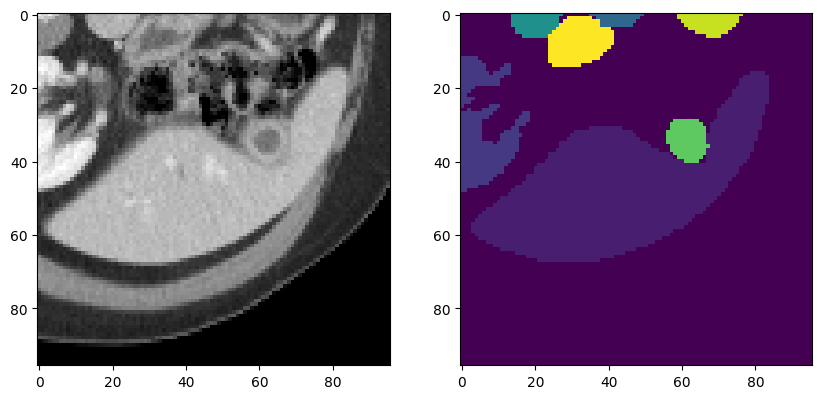

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(sample[1]['img'][0, :, :, 50], cmap='gray')
axs[1].imshow(sample[1]['label'][0, :, :, 50])
plt.show()

Let's see what happens when using `DataLoader`.

In [8]:
loader = DataLoader(dataset, shuffle=False)
data_dict = first(loader)
imgs = data_dict['img']
labels = data_dict['label']

In [9]:
imgs.shape, labels.shape

(torch.Size([2, 1, 96, 96, 96]), torch.Size([2, 1, 96, 96, 96]))

The data is now collated properly.

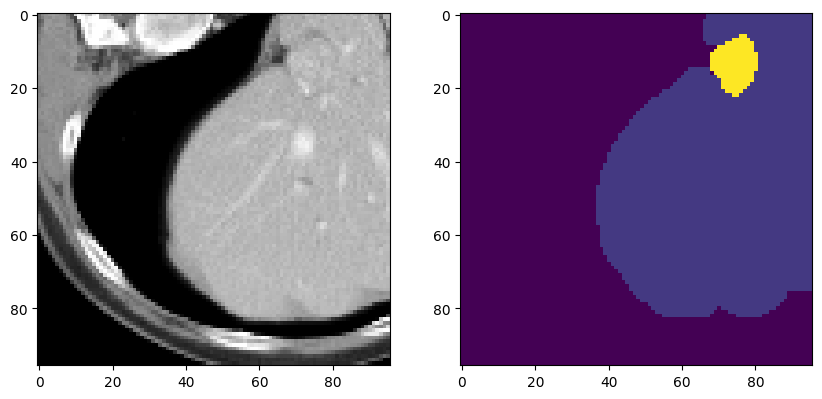

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(imgs[0, 0, :, :, 50], cmap='gray')
axs[1].imshow(labels[0, 0, :, :, 50])
plt.show()